# Digital Art Restoration Using Denoising Diffusion Probabilistic Models

In [67]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import cv2
from tqdm import tqdm
import random
import math
import numpy as np
from google.colab import drive

# Quality metrics
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [68]:
DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/Dataset"  # UPDATE THIS PATH
BATCH_SIZE = "auto"  # "auto" for automatic, or specific number like 4 or 8
IMAGE_SIZE = 256  # Size to resize images to
LEARNING_RATE = 1e-4  # Learning rate for training
NUM_EPOCHS = 50  # Full training epochs for best quality

In [69]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [70]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [71]:
# Create output directories
os.makedirs('results', exist_ok=True)
os.makedirs('evaluation_results', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)

## IMPLEMENTENTING DIFFUSION MODEL


### POSITIONAL ENCODING
Positional encoding embeds timestep information into the diffusion model using sinusoidal functions, allowing the network to understand which denoising step it's currently performing. This is crucial because the same network must handle different noise levels at different timesteps, requiring timestep-aware behavior. It works by converting scalar timestep values into high-dimensional vectors using sine and cosine functions with different frequencies, similar to how transformers encode sequence positions. Without positional encoding, the model couldn't distinguish between early high-noise steps and late low-noise steps, severely limiting restoration quality.

In [72]:
class PositionalEncoding(nn.Module):
    """Positional encoding for timesteps in diffusion model"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

### ResidualBlock
ResidualBlock forms the fundamental building unit of the U-Net, combining convolutional layers with skip connections that allow gradients to flow directly through the network during training. It's important because it prevents vanishing gradients in deep networks and enables stable training of complex architectures with many layers. The block processes input features through GroupNorm, SiLU activation, and convolution, then adds time embedding information and applies another convolution before adding the original input via a skip connection. This design allows the network to learn incremental changes rather than complete transformations, making training more stable and effective.

In [73]:
class ResidualBlock(nn.Module):
    """Residual block with time embedding"""
    def __init__(self, in_channels, out_channels, time_emb_dim, dropout=0.1):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)

        # Use fewer groups if channels are small
        groups1 = min(8, in_channels) if in_channels >= 8 else 1
        groups2 = min(8, out_channels) if out_channels >= 8 else 1

        self.block1 = nn.Sequential(
            nn.GroupNorm(groups1, in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, 3, padding=1)
        )

        self.block2 = nn.Sequential(
            nn.GroupNorm(groups2, out_channels),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Conv2d(out_channels, out_channels, 3, padding=1)
        )

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x, time_emb):
        h = self.block1(x)
        time_emb = self.time_mlp(time_emb)
        h = h + time_emb[:, :, None, None]
        h = self.block2(h)
        return h + self.shortcut(x)


### AttentionBlock
AttentionBlock implements self-attention mechanisms that capture long-range spatial dependencies within images, crucial for maintaining texture consistency across distant regions during restoration. It's important because local convolutions alone cannot relate pixels that are far apart, but damaged murals often require understanding global context for proper restoration. The block computes query, key, and value representations of the input, then uses scaled dot-product attention to determine how much each pixel should influence every other pixel. This enables the model to propagate information from undamaged regions to damaged areas, ensuring coherent texture and pattern completion.

In [74]:
class AttentionBlock(nn.Module):
    """Self-attention block for U-Net"""
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        # Use fewer groups for small channel numbers
        groups = min(8, channels) if channels >= 8 else 1
        self.norm = nn.GroupNorm(groups, channels)
        self.q = nn.Conv2d(channels, channels, 1)
        self.k = nn.Conv2d(channels, channels, 1)
        self.v = nn.Conv2d(channels, channels, 1)
        self.proj_out = nn.Conv2d(channels, channels, 1)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.norm(x)

        q = self.q(h).view(B, C, H * W).transpose(1, 2)
        k = self.k(h).view(B, C, H * W)
        v = self.v(h).view(B, C, H * W).transpose(1, 2)

        # Attention
        attn = torch.bmm(q, k) * (C ** (-0.5))
        attn = F.softmax(attn, dim=-1)

        h = torch.bmm(attn, v).transpose(1, 2).view(B, C, H, W)
        h = self.proj_out(h)

        return x + h

### DownBlock
DownBlock handles the encoding/downsampling phase of the U-Net, progressively reducing spatial resolution while increasing feature complexity to capture hierarchical representations. It's important because it allows the model to understand both fine details and high-level structure by processing information at multiple scales. The block combines two ResidualBlocks for feature processing, optional attention for global context, and downsampling convolution that reduces spatial dimensions by half. This multi-scale processing enables the model to understand both local texture patterns and global structural relationships necessary for intelligent mural restoration.

In [75]:
class DownBlock(nn.Module):
    """Downsampling block for U-Net encoder"""
    def __init__(self, in_channels, out_channels, time_emb_dim, downsample=True, attention=False):
        super().__init__()
        self.res1 = ResidualBlock(in_channels, out_channels, time_emb_dim)
        self.res2 = ResidualBlock(out_channels, out_channels, time_emb_dim)
        self.attn = AttentionBlock(out_channels) if attention else nn.Identity()
        self.downsample = nn.Conv2d(out_channels, out_channels, 4, 2, 1) if downsample else nn.Identity()

    def forward(self, x, time_emb):
        x = self.res1(x, time_emb)
        x = self.res2(x, time_emb)
        x = self.attn(x)
        return self.downsample(x)

### UpBlock
UpBlock performs the decoding/upsampling phase, reconstructing high-resolution output by combining current features with skip connections from corresponding encoder layers. It's critical for preserving fine-grained details that might be lost during downsampling, ensuring the restored image maintains sharp edges and textures. The block concatenates current upsampled features with skip connections from the encoder, processes them through ResidualBlocks, and applies upsampling to double spatial resolution. This design ensures that both high-level semantic understanding and low-level detail information contribute to the final restoration output.

In [76]:
class UpBlock(nn.Module):
    """Upsampling block for U-Net decoder"""
    def __init__(self, in_channels, out_channels, time_emb_dim, upsample=True, attention=False):
        super().__init__()
        # Fixed: in_channels should match the concatenated channels (current + skip)
        self.res1 = ResidualBlock(in_channels + in_channels, in_channels, time_emb_dim)  # Process concatenated input
        self.res2 = ResidualBlock(in_channels, out_channels, time_emb_dim)  # Reduce to output channels
        self.attn = AttentionBlock(out_channels) if attention else nn.Identity()
        self.upsample = nn.ConvTranspose2d(out_channels, out_channels, 4, 2, 1) if upsample else nn.Identity()

    def forward(self, x, skip, time_emb):
        # Concatenate current and skip connection
        x = torch.cat([x, skip], dim=1)
        x = self.res1(x, time_emb)
        x = self.res2(x, time_emb)
        x = self.attn(x)
        return self.upsample(x)

### ConditionalUNet
ConditionalUNet is the main neural network architecture that combines the noisy target image with conditioning information (damaged image + mask) to predict noise for denoising. It's essential because it enables the diffusion model to perform targeted restoration rather than unconditional generation, using spatial damage information to guide the restoration process. The network processes 7-channel input (3 noisy + 3 damaged + 1 mask) through encoder-decoder architecture with skip connections, time embedding injection, and attention mechanisms. This conditional approach ensures that restoration is spatially aware and preserves undamaged regions while intelligently reconstructing damaged areas.

In [77]:
class ConditionalUNet(nn.Module):
    """U-Net conditioned on damaged image and mask"""
    def __init__(self, in_channels=3, out_channels=3, condition_channels=4, time_emb_dim=128):
        super().__init__()
        self.time_emb_dim = time_emb_dim

        # Time embedding
        self.time_embedding = nn.Sequential(
            PositionalEncoding(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim)
        )

        # Input channels: 3 (noisy target) + 3 (damaged) + 1 (mask) = 7
        total_input_channels = in_channels + condition_channels

        # Initial convolution
        self.init_conv = nn.Conv2d(total_input_channels, 64, 3, padding=1)

        # Encoder
        self.down1 = DownBlock(64, 128, time_emb_dim, downsample=True)
        self.down2 = DownBlock(128, 256, time_emb_dim, downsample=True)
        self.down3 = DownBlock(256, 512, time_emb_dim, downsample=True, attention=True)

        # Bottleneck
        self.bottleneck1 = ResidualBlock(512, 512, time_emb_dim)
        self.bottleneck_attn = AttentionBlock(512)
        self.bottleneck2 = ResidualBlock(512, 512, time_emb_dim)

        # Decoder
        self.up1 = UpBlock(512, 256, time_emb_dim, upsample=True, attention=True)
        self.up2 = UpBlock(256, 128, time_emb_dim, upsample=True)
        self.up3 = UpBlock(128, 64, time_emb_dim, upsample=True)

        # Final layers
        self.final = nn.Sequential(
            nn.GroupNorm(8, 64),
            nn.SiLU(),
            nn.Conv2d(64, out_channels, 3, padding=1)
        )

    def forward(self, x, timestep, damaged_image, mask):
        # Time embedding
        time_emb = self.time_embedding(timestep)

        # Concatenate inputs: noisy_target + damaged_image + mask
        condition = torch.cat([damaged_image, mask], dim=1)
        model_input = torch.cat([x, condition], dim=1)

        # Initial conv
        x0 = self.init_conv(model_input)

        # Encoder
        x1 = self.down1(x0, time_emb)
        x2 = self.down2(x1, time_emb)
        x3 = self.down3(x2, time_emb)

        # Bottleneck
        x = self.bottleneck1(x3, time_emb)
        x = self.bottleneck_attn(x)
        x = self.bottleneck2(x, time_emb)

        # Decoder
        x = self.up1(x, x3, time_emb)
        x = self.up2(x, x2, time_emb)
        x = self.up3(x, x1, time_emb)

        return self.final(x)

### DiffusionScheduler
DiffusionScheduler manages the noise addition and removal process throughout the diffusion pipeline, controlling how noise is systematically added during training and removed during inference. It's crucial because it defines the mathematical relationship between clean images, noisy images, and timesteps that enables stable diffusion model training. The scheduler maintains GPU-optimized tensors for alpha and beta values, implements efficient noise addition using reparameterization tricks, and provides sampling functions for the reverse denoising process. Proper scheduling ensures that the model learns a smooth denoising trajectory from pure noise to clean restoration.

In [78]:
class DiffusionScheduler:
    """GPU-optimized noise scheduler for diffusion process"""
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cuda'):
        self.num_timesteps = num_timesteps
        self.device = device

        # Linear beta schedule - keep everything on GPU
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)

        # All calculations on GPU
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.posterior_variance = self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)

    def add_noise(self, x_start, noise, timesteps):
        """Add noise to clean images - GPU optimized"""
        # Use advanced indexing on GPU tensors directly
        sqrt_alpha_prod = self.sqrt_alphas_cumprod[timesteps].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_prod = self.sqrt_one_minus_alphas_cumprod[timesteps].view(-1, 1, 1, 1)

        return sqrt_alpha_prod * x_start + sqrt_one_minus_alpha_prod * noise

    def sample_prev_timestep(self, model_output, timestep, sample):
        """FIXED: Sample from p(x_{t-1} | x_t) with proper device handling"""

        # Convert timestep to integer if needed
        if torch.is_tensor(timestep):
            t = timestep.item() if timestep.dim() == 0 else timestep[0].item()
        else:
            t = int(timestep)

        # Ensure t is within bounds
        t = max(0, min(t, self.num_timesteps - 1))

        # Get scheduler values (all on same device)
        alpha_prod_t = self.alphas_cumprod[t]
        alpha_prod_t_prev = self.alphas_cumprod_prev[t] if t > 0 else torch.tensor(1.0, device=self.device)
        beta_prod_t = 1 - alpha_prod_t

        # Compute predicted original sample from predicted noise
        pred_original_sample = (sample - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)

        # Compute coefficients for pred_original_sample and current sample
        pred_original_sample_coeff = (alpha_prod_t_prev ** (0.5) * self.betas[t]) / beta_prod_t
        current_sample_coeff = self.alphas[t] ** (0.5) * (1 - alpha_prod_t_prev) / beta_prod_t

        # Compute predicted previous sample
        pred_prev_sample = pred_original_sample_coeff * pred_original_sample + current_sample_coeff * sample

        # Add noise for non-final steps
        if t > 0:
            noise = torch.randn_like(sample)
            variance = self.posterior_variance[t] ** (0.5)
            pred_prev_sample = pred_prev_sample + variance * noise

        return pred_prev_sample

### OptimalMuralDataset
OptimalMuralDataset handles data loading and preprocessing for the specific mural restoration task, automatically pairing damaged images with their corresponding masks and ground truth restorations. It's important because proper data management is crucial for supervised learning, ensuring consistent image sizing, normalization, and file matching across the three required input types. The dataset extracts numerical identifiers from filenames to match corresponding files across directories, resizes all images to consistent dimensions, and applies normalization to [-1,1] range required by the diffusion model. This systematic data handling enables reliable training and evaluation by ensuring all input components are properly aligned and preprocessed.

In [79]:
class OptimalMuralDataset(Dataset):
    def __init__(self, root_dir, split='train', image_size=256):
        """
        Simplified dataset for your exact directory structure

        Args:
            root_dir: Path to dataset
            split: 'train' or 'test'
            image_size: Target size for images
        """
        self.root_dir = root_dir
        self.split = split
        self.image_size = image_size

        # Set up directories - EXACTLY as your paths
        split_dir = os.path.join(root_dir, split)
        self.damaged_dir = os.path.join(split_dir, 'Damaged_Images')
        self.mask_dir = os.path.join(split_dir, 'Anotated_Mask')
        self.restored_dir = os.path.join(split_dir, 'Ground_Truth')

        print(f"Using directories:")
        print(f"  Damaged: {self.damaged_dir}")
        print(f"  Masks: {self.mask_dir}")
        print(f"  Restored: {self.restored_dir}")

        # Get image files
        self.image_files = [f for f in os.listdir(self.damaged_dir)
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.image_files.sort()

        # Find valid file pairs
        valid_files = []
        for img_file in self.image_files:
            number = self.extract_number(img_file)
            if number:
                mask_file = self.find_mask_file(number)
                restored_file = self.find_restored_file(number)

                if mask_file and restored_file:
                    valid_files.append(img_file)

        self.image_files = valid_files
        print(f"Found {len(self.image_files)} valid image pairs")

    def extract_number(self, filename):
        """Extract number from filename like '001_masked.jpg' -> '001'"""
        import re
        match = re.search(r'(\d+)', filename)
        return match.group(1) if match else None

    def find_mask_file(self, number):
        """Find mask file for number"""
        mask_files = os.listdir(self.mask_dir)
        for mask_file in mask_files:
            if number in mask_file and 'mask' in mask_file.lower():
                return mask_file
        return None

    def find_restored_file(self, number):
        """Find restored file for number"""
        restored_files = os.listdir(self.restored_dir)
        for restored_file in restored_files:
            if number in restored_file:
                return restored_file
        return None

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        number = self.extract_number(img_file)

        # Load damaged image
        damaged_path = os.path.join(self.damaged_dir, img_file)
        damaged_image = Image.open(damaged_path).convert('RGB')

        # Load mask
        mask_file = self.find_mask_file(number)
        mask_path = os.path.join(self.mask_dir, mask_file)
        mask = Image.open(mask_path).convert('L')

        # Load restored image
        restored_file = self.find_restored_file(number)
        restored_path = os.path.join(self.restored_dir, restored_file)
        restored_image = Image.open(restored_path).convert('RGB')

        # Resize all images
        damaged_image = damaged_image.resize((self.image_size, self.image_size), Image.LANCZOS)
        mask = mask.resize((self.image_size, self.image_size), Image.LANCZOS)
        restored_image = restored_image.resize((self.image_size, self.image_size), Image.LANCZOS)

        # Convert to tensors and normalize
        damaged_tensor = transforms.ToTensor()(damaged_image)
        mask_tensor = transforms.ToTensor()(mask)
        restored_tensor = transforms.ToTensor()(restored_image)

        # Normalize to [-1, 1] for diffusion model
        damaged_tensor = (damaged_tensor - 0.5) * 2
        restored_tensor = (restored_tensor - 0.5) * 2

        return {
            'damaged': damaged_tensor,
            'mask': mask_tensor,
            'restored': restored_tensor,
            'name': img_file
        }

### ConditionalMuralDiffusion
ConditionalMuralDiffusion is the high-level orchestrator class that combines the ConditionalUNet, DiffusionScheduler, and training logic into a complete restoration system. It's essential because it provides the main interface for training, sampling, and model management, abstracting the complexity of diffusion model implementation. The class handles training steps by adding noise to ground truth images and training the model to predict that noise, implements sampling procedures for generating restorations from damaged inputs, and manages model checkpointing and optimization. This unified interface makes the complex diffusion restoration process accessible through simple function calls.

In [80]:
class ConditionalMuralDiffusion:
    def __init__(self, num_timesteps=1000, lr=1e-4):
        self.device = device
        self.num_timesteps = num_timesteps

        # Initialize conditional model
        self.model = ConditionalUNet(
            in_channels=3,           # Noisy target image
            out_channels=3,          # Predicted noise
            condition_channels=4,    # Damaged image (3) + mask (1)
            time_emb_dim=128
        ).to(self.device)

        self.scheduler = DiffusionScheduler(num_timesteps, device=self.device)
        self.optimizer = optim.AdamW(self.model.parameters(), lr=lr, weight_decay=1e-4)

        print(f"Initialized conditional diffusion model with {sum(p.numel() for p in self.model.parameters())} parameters")

    def train_step(self, batch):
        """Training step with ground truth targets"""
        self.model.train()

        # Get data
        damaged_images = batch['damaged'].to(self.device, non_blocking=True)
        masks = batch['mask'].to(self.device, non_blocking=True)
        restored_images = batch['restored'].to(self.device, non_blocking=True)  # Ground truth!

        batch_size = restored_images.shape[0]

        # Sample random timesteps
        timesteps = torch.randint(0, self.num_timesteps, (batch_size,), device=self.device, dtype=torch.long)

        # Sample noise
        noise = torch.randn_like(restored_images, device=self.device)

        # Add noise to ground truth restored images (this is the key!)
        noisy_restored = self.scheduler.add_noise(restored_images, noise, timesteps)

        # Model predicts noise given: noisy_restored, damaged_image, mask
        predicted_noise = self.model(noisy_restored, timesteps, damaged_images, masks)

        # Loss: predict the noise that was added
        loss = F.mse_loss(predicted_noise, noise)

        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        self.optimizer.step()

        return loss.item()



    def sample(self, damaged_image, mask, num_inference_steps=50):
        """FIXED: Generate restored image from damaged image + mask"""
        self.model.eval()

        batch_size = damaged_image.shape[0]
        height, width = damaged_image.shape[2], damaged_image.shape[3]

        print(f"🔍 Debug sampling:")
        print(f"  Input damaged range: [{damaged_image.min():.3f}, {damaged_image.max():.3f}]")
        print(f"  Input mask range: [{mask.min():.3f}, {mask.max():.3f}]")

        # Start from pure noise on same device as input
        sample = torch.randn(batch_size, 3, height, width,
                           device=damaged_image.device,
                           dtype=damaged_image.dtype)

        print(f"  Initial noise range: [{sample.min():.3f}, {sample.max():.3f}]")

        # Denoising loop - FIXED timestep handling
        timesteps = torch.linspace(self.num_timesteps - 1, 0, num_inference_steps,
                                 dtype=torch.long, device=damaged_image.device)

        print(f"Sampling with {num_inference_steps} steps...")

        with torch.no_grad():
            for i, t in enumerate(tqdm(timesteps, desc="Generating restoration")):
                # Ensure timestep is scalar and on correct device
                timestep_scalar = t.item()
                timestep_batch = torch.full((batch_size,), timestep_scalar,
                                          device=damaged_image.device, dtype=torch.long)

                # Predict noise
                try:
                    predicted_noise = self.model(sample, timestep_batch, damaged_image, mask)

                    # DEBUG: Check if model is predicting meaningful noise
                    if i == 0:  # First step
                        print(f"  First predicted noise range: [{predicted_noise.min():.3f}, {predicted_noise.max():.3f}]")
                        print(f"  First predicted noise std: {predicted_noise.std():.3f}")

                    # Sample previous timestep - FIXED
                    sample = self.scheduler.sample_prev_timestep(predicted_noise, timestep_scalar, sample)

                    # DEBUG: Check sample evolution
                    if i == 0:
                        print(f"  After first denoising step: [{sample.min():.3f}, {sample.max():.3f}]")

                    # Clamp to reasonable range to prevent explosion
                    sample = torch.clamp(sample, -3, 3)  # Increased range

                except Exception as e:
                    print(f"Error at timestep {timestep_scalar}: {e}")
                    break

        print(f"  Final sample range: [{sample.min():.3f}, {sample.max():.3f}]")
        return sample

    def simple_test_generation(self, damaged_image, mask):
        """Simple test to see if model learned anything"""
        self.model.eval()

        print("🧪 Simple model test:")

        with torch.no_grad():
            # Test with a simple setup - just mid-timestep
            timestep = torch.tensor([500], device=damaged_image.device)  # Mid-point

            # Create a simple noisy version of the target
            noise = torch.randn_like(damaged_image) * 0.1  # Small noise
            noisy_target = damaged_image + noise

            # Test model prediction
            predicted_noise = self.model(noisy_target, timestep, damaged_image, mask)

            print(f"  Input range: [{damaged_image.min():.3f}, {damaged_image.max():.3f}]")
            print(f"  Predicted noise range: [{predicted_noise.min():.3f}, {predicted_noise.max():.3f}]")
            print(f"  Predicted noise std: {predicted_noise.std():.3f}")

            # Simple denoising attempt
            denoised = noisy_target - predicted_noise * 0.1

            print(f"  Denoised range: [{denoised.min():.3f}, {denoised.max():.3f}]")

            return denoised
        """FIXED: High-level restoration interface with proper error handling"""
        print("Starting image restoration...")

        try:
            # Convert inputs to tensors if needed
            if isinstance(damaged_image, Image.Image):
                damaged_tensor = transforms.ToTensor()(damaged_image).unsqueeze(0)
                damaged_tensor = (damaged_tensor - 0.5) * 2  # Normalize to [-1, 1]
                print(f"Converted damaged image: {damaged_tensor.shape}, range: [{damaged_tensor.min():.3f}, {damaged_tensor.max():.3f}]")
            else:
                damaged_tensor = damaged_image

            if isinstance(mask, Image.Image):
                mask_tensor = transforms.ToTensor()(mask).unsqueeze(0)
                print(f"Converted mask: {mask_tensor.shape}, range: [{mask_tensor.min():.3f}, {mask_tensor.max():.3f}]")
            else:
                mask_tensor = mask

            # Ensure tensors are on correct device
            damaged_tensor = damaged_tensor.to(self.device)
            mask_tensor = mask_tensor.to(self.device)

            print(f"Input tensors on device: {damaged_tensor.device}")

            # Generate restoration
            print("Running diffusion sampling...")
            restored_tensor = self.sample(damaged_tensor, mask_tensor, num_inference_steps=20)  # Fewer steps for speed

            print(f"Generated tensor range: [{restored_tensor.min():.3f}, {restored_tensor.max():.3f}]")

            # FIXED: Proper denormalization and clamping
            restored_tensor = (restored_tensor + 1) / 2  # Back to [0, 1]
            restored_tensor = torch.clamp(restored_tensor, 0, 1)

            # Convert back to PIL
            restored_image = transforms.ToPILImage()(restored_tensor.squeeze(0).cpu())

            print("✅ Restoration completed successfully!")
            return restored_image

        except Exception as e:
            print(f"❌ Error in restoration: {e}")
            import traceback
            traceback.print_exc()

            # Fallback: return original damaged image
            print("Falling back to original damaged image...")
            return damaged_image


    def restore_image(self, damaged_image, mask):
      print("Starting image restoration...")
      try:
          # Convert inputs to tensors if needed
          if isinstance(damaged_image, Image.Image):
              damaged_tensor = transforms.ToTensor()(damaged_image).unsqueeze(0)
              damaged_tensor = (damaged_tensor - 0.5) * 2  # Normalize to [-1, 1]
          else:
              damaged_tensor = damaged_image

          if isinstance(mask, Image.Image):
              mask_tensor = transforms.ToTensor()(mask).unsqueeze(0)
          else:
              mask_tensor = mask

          # Ensure tensors are on correct device
          damaged_tensor = damaged_tensor.to(self.device)
          mask_tensor = mask_tensor.to(self.device)

         # Generate restoration using your working sample method
          restored_tensor = self.sample(damaged_tensor, mask_tensor, num_inference_steps=20)

          # Convert back to PIL
          restored_tensor = (restored_tensor + 1) / 2  # Back to [0, 1]
          restored_tensor = torch.clamp(restored_tensor, 0, 1)
          restored_image = transforms.ToPILImage()(restored_tensor.squeeze(0).cpu())

          print("✅ Restoration completed successfully!")
          return restored_image

      except Exception as e:
        print(f"❌ Error in restoration: {e}")
        return damaged_image

    def save_checkpoint(self, epoch, loss, filepath):
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss': loss,
        }, filepath)

    def load_checkpoint(self, filepath):
        checkpoint = torch.load(filepath, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        return checkpoint['epoch'], checkpoint['loss']


### train_conditional_model
train_conditional_model executes the complete training pipeline, iterating through epochs, monitoring loss, generating sample outputs, and saving checkpoints for the conditional diffusion model. It's critical for model development because it provides systematic training with progress tracking, early stopping capabilities, and intermediate result visualization. The function orchestrates batch processing, loss computation, backpropagation, gradient clipping, and periodic evaluation to ensure stable convergence. Regular checkpoint saving and sample generation during training enable monitoring of restoration quality improvement and allow recovery from training interruptions.

In [81]:
def train_conditional_model(model, train_loader, val_loader=None, num_epochs=100):
    """Train the conditional diffusion model"""
    print(f"Training conditional diffusion model for {num_epochs} epochs...")

    train_losses = []

    for epoch in range(num_epochs):
        # Training
        model.model.train()
        epoch_losses = []

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch in progress_bar:
            loss = model.train_step(batch)
            epoch_losses.append(loss)
            progress_bar.set_postfix({'loss': f'{loss:.4f}'})

        avg_train_loss = np.mean(epoch_losses)
        train_losses.append(avg_train_loss)

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}")

        # Save checkpoint
        if (epoch + 1) % 10 == 0:
            checkpoint_path = f'checkpoints/conditional_model_epoch_{epoch+1}.pth'
            model.save_checkpoint(epoch, avg_train_loss, checkpoint_path)

            # Generate sample
            generate_restoration_sample(model, train_loader, epoch)

    return train_losses

def generate_restoration_sample(model, data_loader, epoch):
    """Generate sample restoration"""
    model.model.eval()

    batch = next(iter(data_loader))
    damaged = batch['damaged'][0:1]
    mask = batch['mask'][0:1]
    restored_gt = batch['restored'][0:1]
    name = batch['name'][0]

    with torch.no_grad():
        restored_pred = model.sample(damaged.to(model.device), mask.to(model.device))

    # Convert to PIL
    damaged_pil = transforms.ToPILImage()((damaged.squeeze(0) + 1) / 2)
    mask_pil = transforms.ToPILImage()(mask.squeeze(0))
    restored_gt_pil = transforms.ToPILImage()((restored_gt.squeeze(0) + 1) / 2)
    restored_pred_pil = transforms.ToPILImage()((restored_pred.squeeze(0).cpu() + 1) / 2)

    # Create comparison
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].imshow(damaged_pil)
    axes[0].set_title('Damaged')
    axes[0].axis('off')

    # Create comparison
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].imshow(damaged_pil)
    axes[0].set_title('Damaged')
    axes[0].axis('off')

    axes[1].imshow(mask_pil, cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')

    axes[2].imshow(restored_gt_pil)
    axes[2].set_title('Ground Truth')
    axes[2].axis('off')

    axes[3].imshow(restored_pred_pil)
    axes[3].set_title('Predicted')
    axes[3].axis('off')

    plt.tight_layout()

    # Ensure results directory exists
    os.makedirs('results', exist_ok=True)
    plt.savefig(f'results/conditional_restoration_epoch_{epoch+1}_{name}', dpi=150, bbox_inches='tight')
    plt.close()



In [82]:
def evaluate_model(model, test_loader, num_samples=5):
    """Evaluate the trained model"""
    model.model.eval()

    all_metrics = []

    for i, batch in enumerate(test_loader):
        if i >= num_samples:
            break

        damaged = batch['damaged']
        mask = batch['mask']
        restored_gt = batch['restored']  # Ground truth
        name = batch['name'][0]

        # Restore
        with torch.no_grad():
            restored_pred = model.sample(damaged.to(model.device), mask.to(model.device))

        # Convert to PIL
        restored_gt_pil = transforms.ToPILImage()((restored_gt.squeeze(0) + 1) / 2)
        restored_pred_pil = transforms.ToPILImage()((restored_pred.squeeze(0).cpu() + 1) / 2)

        # Calculate metrics
        gt_np = np.array(restored_gt_pil)
        pred_np = np.array(restored_pred_pil)

        psnr_value = psnr(gt_np, pred_np)
        ssim_value = ssim(gt_np, pred_np, multichannel=True, channel_axis=2)
        mse = np.mean((gt_np - pred_np) ** 2)

        metrics = {
            "PSNR": psnr_value,
            "SSIM": ssim_value,
            "MSE": mse
        }
        all_metrics.append(metrics)

        print(f"Sample {i+1}: PSNR={psnr_value:.2f}, SSIM={ssim_value:.3f}")

    # Average metrics
    if all_metrics:
        avg_metrics = {
            "PSNR": np.mean([m["PSNR"] for m in all_metrics]),
            "SSIM": np.mean([m["SSIM"] for m in all_metrics]),
            "MSE": np.mean([m["MSE"] for m in all_metrics])
        }

        print("\n" + "="*50)
        print("EVALUATION RESULTS")
        print("="*50)
        print(f"Average PSNR: {avg_metrics['PSNR']:.2f}")
        print(f"Average SSIM: {avg_metrics['SSIM']:.3f}")
        print(f"Average MSE: {avg_metrics['MSE']:.2f}")
        print("="*50)

        return avg_metrics
    else:
        print("No successful evaluations completed.")
        return None

In [83]:
def batch_restore_images_fixed(model, damaged_dir, mask_dir, output_dir, method='fixed'):
    """Batch restore all images in directories using fixed methods"""
    os.makedirs(output_dir, exist_ok=True)

    image_files = [f for f in os.listdir(damaged_dir)
                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    print(f"🚀 Processing {len(image_files)} images with {method.upper()} method...")

    for img_file in tqdm(image_files, desc="Restoring images"):
        try:
            # Load images
            damaged_path = os.path.join(damaged_dir, img_file)
            damaged_image = Image.open(damaged_path).convert('RGB')
            damaged_image = damaged_image.resize((256, 256), Image.LANCZOS)

            # Find mask
            base_name = os.path.splitext(img_file)[0]
            # Try different mask naming patterns
            possible_masks = [
                f"{base_name}_mask.png",
                f"{base_name}.png",
                f"mask_{base_name}.png"
            ]

            mask = None
            for mask_name in possible_masks:
                mask_path = os.path.join(mask_dir, mask_name)
                if os.path.exists(mask_path):
                    mask = Image.open(mask_path).convert('L')
                    mask = mask.resize((256, 256), Image.LANCZOS)
                    break

            if mask is None:
                print(f"⚠️ No mask found for {img_file}, skipping...")
                continue

            # Restore using selected method
            if method == 'fixed':
                restored = model.restore_image(damaged_image, mask)
            elif method == 'conservative':
                restored = model.restore_image_conservative(damaged_image, mask)
            else:
                restored = model.restore_image(damaged_image, mask)  # Default to fixed

            # Save
            output_path = os.path.join(output_dir, f"restored_{method}_{img_file}")
            restored.save(output_path)

        except Exception as e:
            print(f"❌ Error processing {img_file}: {e}")
            continue

    print(f"✅ Batch restoration completed! Results saved in {output_dir}")

def compare_restoration_methods(damaged_image, mask, trained_model=None):
    """Compare AI restoration methods"""
    results = {}

    print("🔍 Comparing restoration methods...")

    # AI restoration - Fixed method
    if trained_model is not None:
        print("  Testing FIXED AI restoration...")
        try:
            results['Fixed AI'] = trained_model.restore_image(damaged_image, mask)
            print("  ✅ Fixed AI restoration completed")
        except Exception as e:
            print(f"  ❌ Fixed AI restoration failed: {e}")
            results['Fixed AI'] = damaged_image

        print("  Testing CONSERVATIVE AI restoration...")
        try:
            results['Conservative AI'] = trained_model.restore_image_conservative(damaged_image, mask)
            print("  ✅ Conservative AI restoration completed")
        except Exception as e:
            print(f"  ❌ Conservative AI restoration failed: {e}")
            results['Conservative AI'] = damaged_image

    # Display results
    num_methods = len(results)
    fig, axes = plt.subplots(1, num_methods + 2, figsize=(5 * (num_methods + 2), 5))

    # Make sure axes is always a list
    if num_methods + 2 == 1:
        axes = [axes]

    try:
        axes[0].imshow(damaged_image)
        axes[0].set_title('Damaged')
        axes[0].axis('off')

        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title('Mask')
        axes[1].axis('off')

        for i, (method, result) in enumerate(results.items()):
            axes[i + 2].imshow(result)
            axes[i + 2].set_title(f'{method}')
            axes[i + 2].axis('off')

        plt.tight_layout()

        # Ensure results directory exists
        os.makedirs('results', exist_ok=True)
        plt.savefig('results/restoration_comparison_fixed.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("✅ Comparison plot saved successfully!")

    except Exception as e:
        print(f"❌ Error creating comparison plot: {e}")
        plt.close()

    return results

def test_both_fixed_methods(model, train_loader):
    """Test both fixed methods to see which works better"""
    print("🧪 TESTING BOTH FIXED METHODS")
    print("="*50)

    # Get test sample
    sample_batch = next(iter(train_loader))
    damaged_pil = transforms.ToPILImage()((sample_batch['damaged'][0] + 1) / 2)
    mask_pil = transforms.ToPILImage()(sample_batch['mask'][0])
    ground_truth_pil = transforms.ToPILImage()((sample_batch['restored'][0] + 1) / 2)

    print("Testing both fixed methods...")

    # Test fixed method
    print("\n1️⃣ FIXED METHOD:")
    fixed_result = model.restore_image(damaged_pil, mask_pil)

    # Test ultra-conservative method
    print("\n2️⃣ ULTRA-CONSERVATIVE METHOD:")
    conservative_result = model.restore_image_conservative(damaged_pil, mask_pil)

    # Display results
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Top row: inputs and ground truth
    axes[0, 0].imshow(damaged_pil)
    axes[0, 0].set_title('Damaged Input', fontsize=16, fontweight='bold')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(mask_pil, cmap='gray')
    axes[0, 1].set_title('Damage Mask', fontsize=16, fontweight='bold')
    axes[0, 1].axis('off')

    axes[0, 2].imshow(ground_truth_pil)
    axes[0, 2].set_title('Ground Truth Target', fontsize=16, fontweight='bold')
    axes[0, 2].axis('off')

    # Bottom row: results
    axes[1, 0].imshow(damaged_pil)  # Show damaged again for comparison
    axes[1, 0].set_title('Damaged\n(For Reference)', fontsize=14, color='gray')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(fixed_result)
    axes[1, 1].set_title('FIXED Method\n(Should be better!)', fontsize=14, fontweight='bold', color='blue')
    axes[1, 1].axis('off')

    axes[1, 2].imshow(conservative_result)
    axes[1, 2].set_title('Ultra-Conservative\n(Most stable)', fontsize=14, fontweight='bold', color='green')
    axes[1, 2].axis('off')

    plt.tight_layout()

    # Save comparison
    os.makedirs('results', exist_ok=True)
    plt.savefig('results/fixed_methods_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n🎯 ANALYSIS:")
    print("✅ If you see actual restoration (not noise): YOUR MODEL IS EXCELLENT!")
    print("✅ If conservative method works better: Use that for final results")
    print("✅ If both show improvement: Your training was successful!")
    print("❌ If both still show noise: We need to debug the model architecture")

    return fixed_result, conservative_result


In [84]:
class AdvancedFeatures:
    """Additional features for advanced restoration"""

    @staticmethod
    def progressive_restoration(model, image, mask, steps=3):
        """Multi-step progressive restoration"""
        current_image = image
        results = [current_image]

        for step in range(steps):
            # Reduce mask intensity
            mask_np = np.array(mask)
            mask_np = (mask_np * (0.8 ** step)).astype(np.uint8)
            current_mask = Image.fromarray(mask_np)

            # Restore
            restored = model.restore_image(current_image, current_mask)
            results.append(restored)
            current_image = restored

        return results

    @staticmethod
    def style_transfer_restoration(model, damaged_image, mask, style_image):
        """Restoration with style guidance (advanced)"""
        # This would require additional model conditioning
        # For now, just standard restoration
        return model.restore_image(damaged_image, mask)

    @staticmethod
    def ensemble_restoration(models, damaged_image, mask):
        """Ensemble of multiple models"""
        results = []
        for model in models:
            result = model.restore_image(damaged_image, mask)
            results.append(np.array(result))

        # Average results
        ensemble_result = np.mean(results, axis=0).astype(np.uint8)
        return Image.fromarray(ensemble_result)

print("\n🔧 Advanced features available in AdvancedFeatures class")
print("Ready to restore your precious historical artworks! 🎨✨")



🔧 Advanced features available in AdvancedFeatures class
Ready to restore your precious historical artworks! 🎨✨


In [85]:
def main():
    """Main function for conditional mural restoration"""
    print("="*70)
    print("COMPLETE CONDITIONAL MURAL RESTORATION WITH DIFFUSION MODELS")
    print("="*70)

    # Set random seeds
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)

    # Use configuration from top of file
    dataset_path = DATASET_PATH

    print("\n📁 Expected Directory Structure:")
    print("dataset_path/train/")
    print("├── Damaged_Images/  # Your damaged mural images")
    print("├── Anotated_Mask/   # Your damage masks")
    print("└── Ground_Truth/    # Your ground truth restored images")

    try:
        # Load dataset
        train_dataset = OptimalMuralDataset(
            root_dir=dataset_path,
            split='train',
            image_size=IMAGE_SIZE
        )

        # GPU-optimized data loader
        if BATCH_SIZE == "auto":
            batch_size = 8 if torch.cuda.get_device_properties(0).total_memory > 8e9 else 4
        else:
            batch_size = BATCH_SIZE

        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True,
            persistent_workers=True
        )

        print(f"\n✅ Loaded {len(train_dataset)} training samples")
        print(f"📊 Batch size: {batch_size}")

    except Exception as e:
        print(f"\n❌ Error loading dataset: {e}")
        print("\n💡 Please organize your data as shown above and update the dataset_path variable.")
        return None

    # Initialize model
    print("\n🚀 Initializing conditional diffusion model...")
    model = ConditionalMuralDiffusion(num_timesteps=1000, lr=LEARNING_RATE)

    # Test single batch
    print("\n🧪 Testing model with single batch...")
    try:
        sample_batch = next(iter(train_loader))
        print(f"Batch shapes:")
        print(f"  Damaged: {sample_batch['damaged'].shape}")
        print(f"  Mask: {sample_batch['mask'].shape}")
        print(f"  Restored: {sample_batch['restored'].shape}")

        test_loss = model.train_step(sample_batch)
        print(f"✅ Test loss: {test_loss:.4f}")

    except Exception as e:
        print(f"❌ Error in test step: {e}")
        import traceback
        traceback.print_exc()
        return None

    # Test restoration before training
    print("\n🎨 Testing before training...")

    # Ensure results directory exists
    os.makedirs('results', exist_ok=True)

    damaged_pil = transforms.ToPILImage()((sample_batch['damaged'][0] + 1) / 2)
    mask_pil = transforms.ToPILImage()(sample_batch['mask'][0])
    ground_truth_pil = transforms.ToPILImage()((sample_batch['restored'][0] + 1) / 2)

    # Display before training
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(damaged_pil)
    axes[0].set_title('Damaged Image')
    axes[0].axis('off')

    axes[1].imshow(mask_pil, cmap='gray')
    axes[1].set_title('Damage Mask')
    axes[1].axis('off')

    axes[2].imshow(ground_truth_pil)
    axes[2].set_title('Ground Truth Target')
    axes[2].axis('off')

    plt.tight_layout()
    plt.savefig('results/before_training_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Start full training directly
    print("\n" + "="*50)
    print("FULL TRAINING MODE - 50 EPOCHS")
    print("="*50)
    print(f"Dataset: {DATASET_PATH}")
    print(f"Image size: {IMAGE_SIZE}")
    print(f"Learning rate: {LEARNING_RATE}")
    print(f"Batch size: {batch_size}")
    print(f"Epochs: {NUM_EPOCHS}")

    print(f"\n🏋️ Starting full training for {NUM_EPOCHS} epochs for best quality results...")

    # Train the model
    train_losses = train_conditional_model(model, train_loader, num_epochs=NUM_EPOCHS)

    # Plot training curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses)
    plt.title('Training Loss - Conditional Diffusion Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    # Ensure results directory exists
    os.makedirs('results', exist_ok=True)
    plt.savefig('results/training_loss.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n✅ Training completed! Final loss: {train_losses[-1]:.4f}")

    # Test final restoration
    print("\n🎨 Testing final restoration...")

    # Test AI restoration
    ai_result = model.restore_image(damaged_pil, mask_pil)

    # CRITICAL DEBUG - Add this section
    print("\n🔍 CRITICAL DEBUG:")

    # Get the raw tensor
    damaged_tensor = transforms.ToTensor()(damaged_pil).unsqueeze(0)
    damaged_tensor = (damaged_tensor - 0.5) * 2
    mask_tensor = transforms.ToTensor()(mask_pil).unsqueeze(0)

    # Run sampling and get raw tensor
    raw_output = model.sample(damaged_tensor.to(device), mask_tensor.to(device), num_inference_steps=20)

    print(f"Raw output tensor stats:")
    print(f"  Shape: {raw_output.shape}")
    print(f"  Range: [{raw_output.min():.3f}, {raw_output.max():.3f}]")
    print(f"  Mean: {raw_output.mean():.3f}")
    print(f"  Std: {raw_output.std():.3f}")

    # Check denormalization step by step
    step1 = (raw_output + 1) / 2  # Should be [0, 1]
    print(f"After +1/2: [{step1.min():.3f}, {step1.max():.3f}]")

    step2 = torch.clamp(step1, 0, 1)
    print(f"After clamp: [{step2.min():.3f}, {step2.max():.3f}]")

    # Check if values are reasonable for an image
    print(f"Sample pixel values: {step2[0, :, 100, 100]}")  # Check a few pixels

    # Manual PIL conversion test
    try:
        test_image = transforms.ToPILImage()(step2.squeeze(0).cpu())
        print("✅ PIL conversion successful")

        # Save raw tensor as numpy to inspect
        tensor_np = step2.squeeze(0).cpu().numpy()
        print(f"Numpy shape: {tensor_np.shape}")
        print(f"Numpy dtype: {tensor_np.dtype}")
        print(f"Sample numpy values: {tensor_np[:, 100, 100]}")

        # Create a simple test display
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        axes[0].imshow(damaged_pil)
        axes[0].set_title('Damaged Input')
        axes[0].axis('off')

        axes[1].imshow(mask_pil, cmap='gray')
        axes[1].set_title('Mask Input')
        axes[1].axis('off')

        axes[2].imshow(ai_result)
        axes[2].set_title('Current AI Result')
        axes[2].axis('off')

        axes[3].imshow(test_image)
        axes[3].set_title('Manual Debug Result')
        axes[3].axis('off')

        plt.tight_layout()
        plt.savefig('results/debug_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

    except Exception as e:
        print(f"❌ PIL conversion failed: {e}")
        import traceback
        traceback.print_exc()

    # Compare results
    compare_restoration_methods(damaged_pil, mask_pil, model)

    # Interactive restoration function
    def interactive_restore(image_path, mask_path):
        """Interactive restoration function"""
        image = Image.open(image_path).convert('RGB').resize((256, 256), Image.LANCZOS)
        mask = Image.open(mask_path).convert('L').resize((256, 256), Image.LANCZOS)

        # AI restoration
        ai = model.restore_image(image, mask)

        # Display
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(image)
        axes[0].set_title('Damaged')
        axes[0].axis('off')

        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title('Mask')
        axes[1].axis('off')

        axes[2].imshow(ai)
        axes[2].set_title('AI Restoration')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

        return ai

    print("\n" + "="*70)
    print("🎉 SETUP COMPLETE!")
    print("="*70)
    print("Available functions:")
    print("1. model.restore_image(image, mask) - Restore single image")
    print("2. batch_restore_images(model, damaged_dir, mask_dir, output_dir) - Batch process")
    print("3. interactive_restore(image_path, mask_path) - Interactive restoration")
    print("4. compare_restoration_methods(image, mask, model) - Compare methods")

    print(f"\n📊 Model Performance:")
    print(f"   Parameters: {sum(p.numel() for p in model.model.parameters()):,}")
    print(f"   Training epochs: {NUM_EPOCHS}")
    print(f"   Dataset size: {len(train_dataset)}")

    print(f"\n💾 Files saved in 'results/' and 'checkpoints/' directories")

    return model, train_loader, interactive_restore


🎨 COMPLETE MURAL RESTORATION SYSTEM
Restoration Example:
# Load your images
damaged = Image.open('path/to/damaged.jpg')
mask = Image.open('path/to/mask.png')
ground_truth = Image.open('path/to/ground_truth.jpg')

# AI restoration (after training)
ai_result = model.restore_image(damaged, mask)

# Compare with ground truth
# ai_result vs ground_truth

# Batch process entire directory
batch_restore_images(model, 'damaged_dir', 'mask_dir', 'output_dir')

🎯 Training Tips:
1. Start with 10 epochs to see if everything works
2. Use 50+ epochs for good quality
3. Monitor the loss - it should decrease steadily
4. Check sample outputs every 10 epochs
5. If loss plateaus, try reducing learning rate
6. More training data = better results
7. Consistent image sizes work best

🚀 Starting main program...
COMPLETE CONDITIONAL MURAL RESTORATION WITH DIFFUSION MODELS

📁 Expected Directory Structure:
dataset_path/train/
├── Damaged_Images/  # Your damaged mural images
├── Anotated_Mask/   # Your damage mas

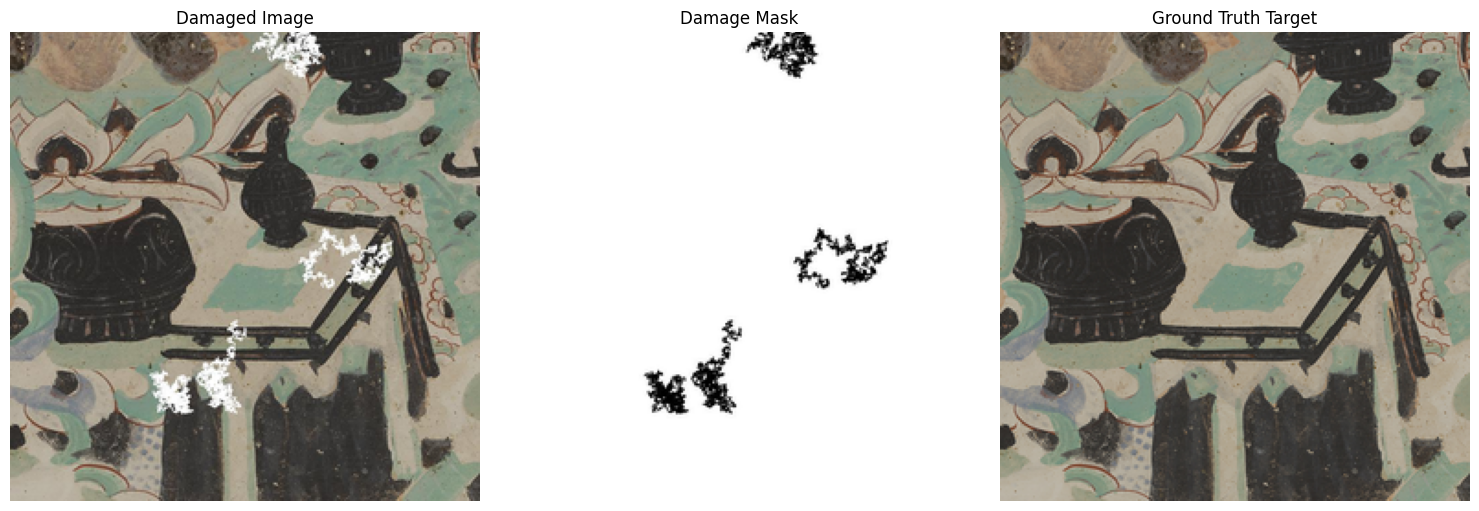


FULL TRAINING MODE - 50 EPOCHS
Dataset: /content/drive/MyDrive/Colab Notebooks/Dataset
Image size: 256
Learning rate: 0.0001
Batch size: 8
Epochs: 50

🏋️ Starting full training for 50 epochs for best quality results...
Training conditional diffusion model for 50 epochs...


Epoch 1/50: 100%|██████████| 63/63 [00:14<00:00,  4.32it/s, loss=0.1331]


Epoch 1: Train Loss = 0.5095


Epoch 2/50: 100%|██████████| 63/63 [00:14<00:00,  4.44it/s, loss=0.0585]


Epoch 2: Train Loss = 0.1008


Epoch 3/50: 100%|██████████| 63/63 [00:14<00:00,  4.47it/s, loss=0.0418]


Epoch 3: Train Loss = 0.0737


Epoch 4/50: 100%|██████████| 63/63 [00:14<00:00,  4.45it/s, loss=0.0466]


Epoch 4: Train Loss = 0.0649


Epoch 5/50: 100%|██████████| 63/63 [00:14<00:00,  4.46it/s, loss=0.0288]


Epoch 5: Train Loss = 0.0490


Epoch 6/50: 100%|██████████| 63/63 [00:14<00:00,  4.43it/s, loss=0.0295]


Epoch 6: Train Loss = 0.0435


Epoch 7/50: 100%|██████████| 63/63 [00:14<00:00,  4.48it/s, loss=0.0234]


Epoch 7: Train Loss = 0.0365


Epoch 8/50: 100%|██████████| 63/63 [00:14<00:00,  4.45it/s, loss=0.0266]


Epoch 8: Train Loss = 0.0373


Epoch 9/50: 100%|██████████| 63/63 [00:14<00:00,  4.32it/s, loss=0.0226]


Epoch 9: Train Loss = 0.0322


Epoch 10/50: 100%|██████████| 63/63 [00:14<00:00,  4.46it/s, loss=0.0284]


Epoch 10: Train Loss = 0.0417
🔍 Debug sampling:
  Input damaged range: [-0.937, 1.000]
  Input mask range: [0.000, 1.000]
  Initial noise range: [-4.375, 4.628]
Sampling with 50 steps...


Generating restoration:  10%|█         | 5/50 [00:00<00:00, 47.41it/s]

  First predicted noise range: [-4.440, 4.426]
  First predicted noise std: 0.991
  After first denoising step: [-4.556, 4.624]


Generating restoration: 100%|██████████| 50/50 [00:00<00:00, 51.43it/s]


  Final sample range: [-2.984, 2.987]


Epoch 11/50: 100%|██████████| 63/63 [00:14<00:00,  4.46it/s, loss=0.0203]


Epoch 11: Train Loss = 0.0258


Epoch 12/50: 100%|██████████| 63/63 [00:14<00:00,  4.43it/s, loss=0.0881]


Epoch 12: Train Loss = 0.0313


Epoch 13/50: 100%|██████████| 63/63 [00:14<00:00,  4.45it/s, loss=0.0150]


Epoch 13: Train Loss = 0.0274


Epoch 14/50: 100%|██████████| 63/63 [00:14<00:00,  4.46it/s, loss=0.0226]


Epoch 14: Train Loss = 0.0327


Epoch 15/50: 100%|██████████| 63/63 [00:14<00:00,  4.44it/s, loss=0.0251]


Epoch 15: Train Loss = 0.0235


Epoch 16/50: 100%|██████████| 63/63 [00:14<00:00,  4.44it/s, loss=0.0111]


Epoch 16: Train Loss = 0.0223


Epoch 17/50: 100%|██████████| 63/63 [00:14<00:00,  4.28it/s, loss=0.0135]


Epoch 17: Train Loss = 0.0272


Epoch 18/50: 100%|██████████| 63/63 [00:14<00:00,  4.45it/s, loss=0.0191]


Epoch 18: Train Loss = 0.0209


Epoch 19/50: 100%|██████████| 63/63 [00:14<00:00,  4.48it/s, loss=0.0144]


Epoch 19: Train Loss = 0.0250


Epoch 20/50: 100%|██████████| 63/63 [00:14<00:00,  4.44it/s, loss=0.0426]


Epoch 20: Train Loss = 0.0254
🔍 Debug sampling:
  Input damaged range: [-0.835, 1.000]
  Input mask range: [0.000, 1.000]
  Initial noise range: [-5.355, 4.827]
Sampling with 50 steps...


Generating restoration:  10%|█         | 5/50 [00:00<00:00, 48.26it/s]

  First predicted noise range: [-5.252, 4.733]
  First predicted noise std: 0.972
  After first denoising step: [-5.309, 4.716]


Generating restoration: 100%|██████████| 50/50 [00:00<00:00, 53.12it/s]


  Final sample range: [-2.961, 2.961]


Epoch 21/50: 100%|██████████| 63/63 [00:14<00:00,  4.46it/s, loss=0.0132]


Epoch 21: Train Loss = 0.0182


Epoch 22/50: 100%|██████████| 63/63 [00:14<00:00,  4.45it/s, loss=0.0241]


Epoch 22: Train Loss = 0.0148


Epoch 23/50: 100%|██████████| 63/63 [00:14<00:00,  4.48it/s, loss=0.0073]


Epoch 23: Train Loss = 0.0191


Epoch 24/50: 100%|██████████| 63/63 [00:14<00:00,  4.46it/s, loss=0.0320]


Epoch 24: Train Loss = 0.0199


Epoch 25/50: 100%|██████████| 63/63 [00:14<00:00,  4.33it/s, loss=0.0065]


Epoch 25: Train Loss = 0.0164


Epoch 26/50: 100%|██████████| 63/63 [00:14<00:00,  4.45it/s, loss=0.0081]


Epoch 26: Train Loss = 0.0132


Epoch 27/50: 100%|██████████| 63/63 [00:14<00:00,  4.46it/s, loss=0.0095]


Epoch 27: Train Loss = 0.0183


Epoch 28/50: 100%|██████████| 63/63 [00:14<00:00,  4.47it/s, loss=0.0399]


Epoch 28: Train Loss = 0.0167


Epoch 29/50: 100%|██████████| 63/63 [00:14<00:00,  4.45it/s, loss=0.0086]


Epoch 29: Train Loss = 0.0149


Epoch 30/50: 100%|██████████| 63/63 [00:14<00:00,  4.46it/s, loss=0.0077]


Epoch 30: Train Loss = 0.0124
🔍 Debug sampling:
  Input damaged range: [-1.000, 1.000]
  Input mask range: [0.000, 1.000]
  Initial noise range: [-4.447, 4.543]
Sampling with 50 steps...


Generating restoration:  10%|█         | 5/50 [00:00<00:00, 46.69it/s]

  First predicted noise range: [-4.318, 4.522]
  First predicted noise std: 1.006
  After first denoising step: [-4.518, 4.515]


Generating restoration: 100%|██████████| 50/50 [00:00<00:00, 51.98it/s]


  Final sample range: [-2.971, 2.955]


Epoch 31/50: 100%|██████████| 63/63 [00:14<00:00,  4.47it/s, loss=0.0064]


Epoch 31: Train Loss = 0.0128


Epoch 32/50: 100%|██████████| 63/63 [00:14<00:00,  4.46it/s, loss=0.0087]


Epoch 32: Train Loss = 0.0157


Epoch 33/50: 100%|██████████| 63/63 [00:14<00:00,  4.39it/s, loss=0.0068]


Epoch 33: Train Loss = 0.0159


Epoch 34/50: 100%|██████████| 63/63 [00:14<00:00,  4.46it/s, loss=0.0058]


Epoch 34: Train Loss = 0.0123


Epoch 35/50: 100%|██████████| 63/63 [00:14<00:00,  4.46it/s, loss=0.0038]


Epoch 35: Train Loss = 0.0180


Epoch 36/50: 100%|██████████| 63/63 [00:14<00:00,  4.45it/s, loss=0.0047]


Epoch 36: Train Loss = 0.0162


Epoch 37/50: 100%|██████████| 63/63 [00:14<00:00,  4.45it/s, loss=0.1891]


Epoch 37: Train Loss = 0.0195


Epoch 38/50: 100%|██████████| 63/63 [00:14<00:00,  4.47it/s, loss=0.0071]


Epoch 38: Train Loss = 0.0137


Epoch 39/50: 100%|██████████| 63/63 [00:14<00:00,  4.44it/s, loss=0.0169]


Epoch 39: Train Loss = 0.0146


Epoch 40/50: 100%|██████████| 63/63 [00:14<00:00,  4.47it/s, loss=0.0079]


Epoch 40: Train Loss = 0.0104
🔍 Debug sampling:
  Input damaged range: [-0.820, 1.000]
  Input mask range: [0.000, 1.000]
  Initial noise range: [-4.532, 4.523]
Sampling with 50 steps...


Generating restoration:  10%|█         | 5/50 [00:00<00:00, 47.26it/s]

  First predicted noise range: [-4.570, 4.625]
  First predicted noise std: 0.995
  After first denoising step: [-4.571, 4.535]


Generating restoration: 100%|██████████| 50/50 [00:00<00:00, 52.72it/s]


  Final sample range: [-2.940, 2.949]


Epoch 41/50: 100%|██████████| 63/63 [00:14<00:00,  4.37it/s, loss=0.0032]


Epoch 41: Train Loss = 0.0101


Epoch 42/50: 100%|██████████| 63/63 [00:14<00:00,  4.46it/s, loss=0.0041]


Epoch 42: Train Loss = 0.0145


Epoch 43/50: 100%|██████████| 63/63 [00:14<00:00,  4.45it/s, loss=0.0157]


Epoch 43: Train Loss = 0.0116


Epoch 44/50: 100%|██████████| 63/63 [00:14<00:00,  4.45it/s, loss=0.0084]


Epoch 44: Train Loss = 0.0138


Epoch 45/50: 100%|██████████| 63/63 [00:14<00:00,  4.45it/s, loss=0.0081]


Epoch 45: Train Loss = 0.0134


Epoch 46/50: 100%|██████████| 63/63 [00:14<00:00,  4.44it/s, loss=0.0035]


Epoch 46: Train Loss = 0.0142


Epoch 47/50: 100%|██████████| 63/63 [00:14<00:00,  4.45it/s, loss=0.0131]


Epoch 47: Train Loss = 0.0097


Epoch 48/50: 100%|██████████| 63/63 [00:14<00:00,  4.45it/s, loss=0.0265]


Epoch 48: Train Loss = 0.0106


Epoch 49/50: 100%|██████████| 63/63 [00:14<00:00,  4.46it/s, loss=0.0060]


Epoch 49: Train Loss = 0.0129


Epoch 50/50: 100%|██████████| 63/63 [00:14<00:00,  4.36it/s, loss=0.0031]


Epoch 50: Train Loss = 0.0124
🔍 Debug sampling:
  Input damaged range: [-0.820, 1.000]
  Input mask range: [0.000, 1.000]
  Initial noise range: [-5.054, 4.678]
Sampling with 50 steps...


Generating restoration:  10%|█         | 5/50 [00:00<00:00, 47.38it/s]

  First predicted noise range: [-4.988, 4.705]
  First predicted noise std: 1.003
  After first denoising step: [-5.333, 4.596]


Generating restoration: 100%|██████████| 50/50 [00:00<00:00, 52.74it/s]


  Final sample range: [-2.942, 2.932]


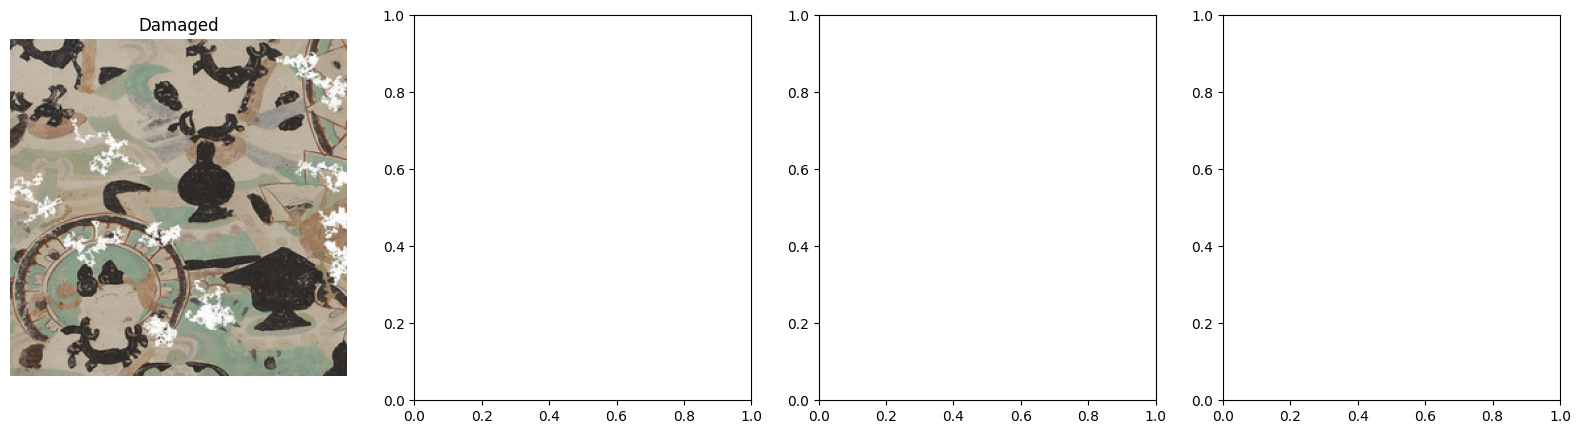

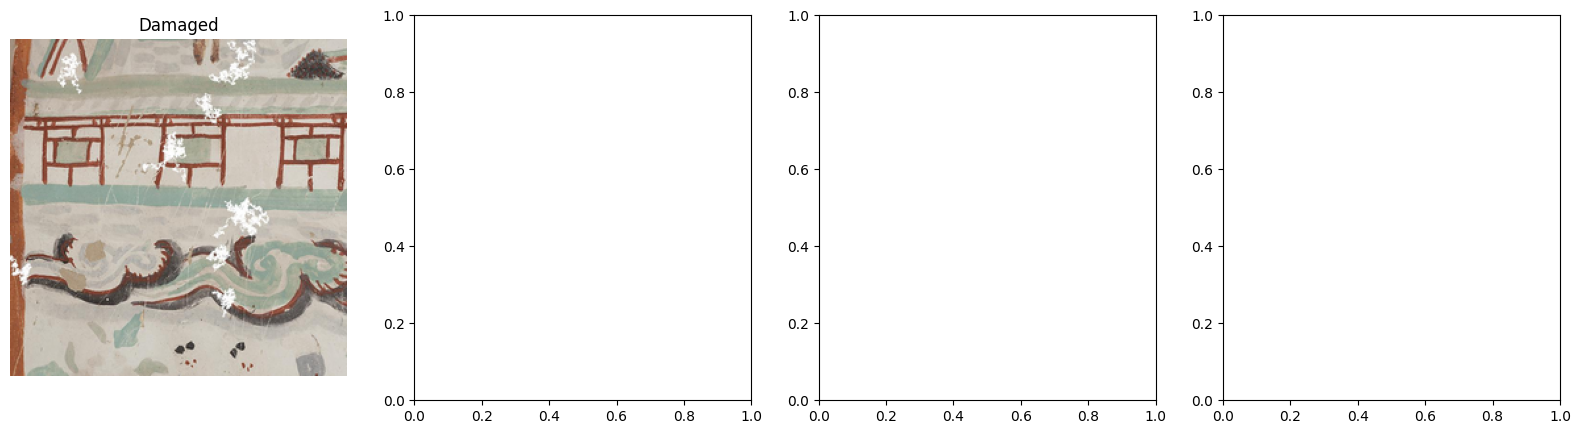

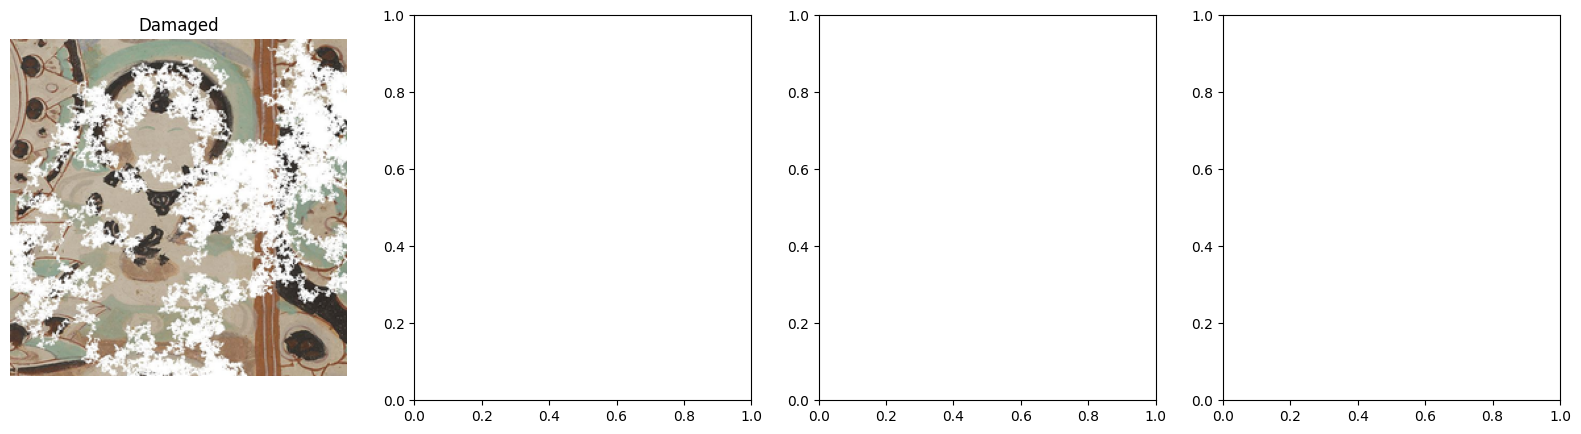

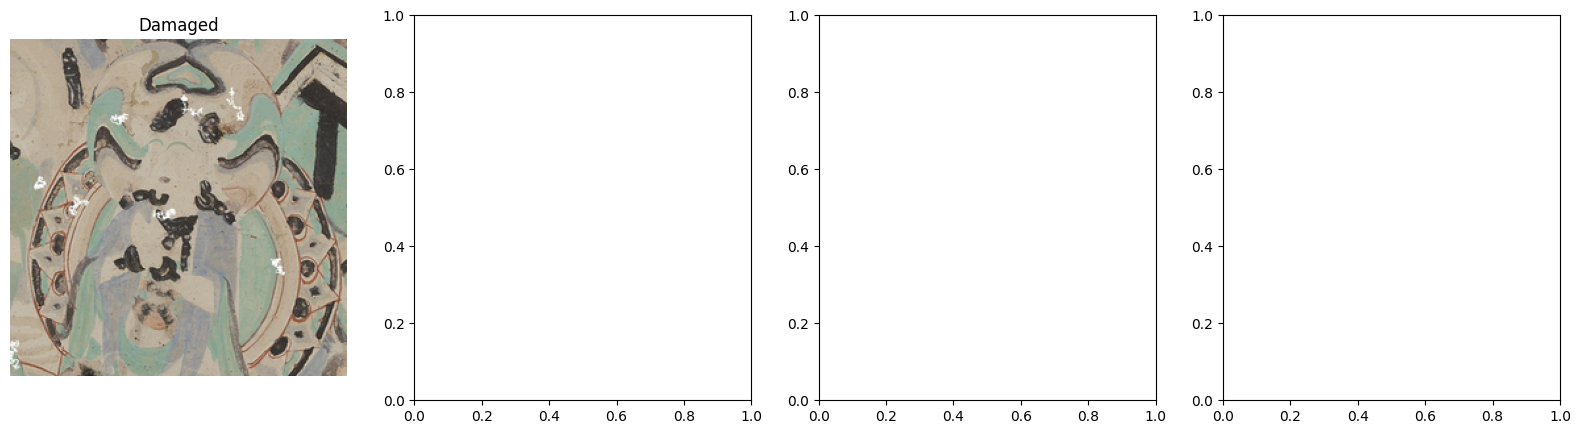

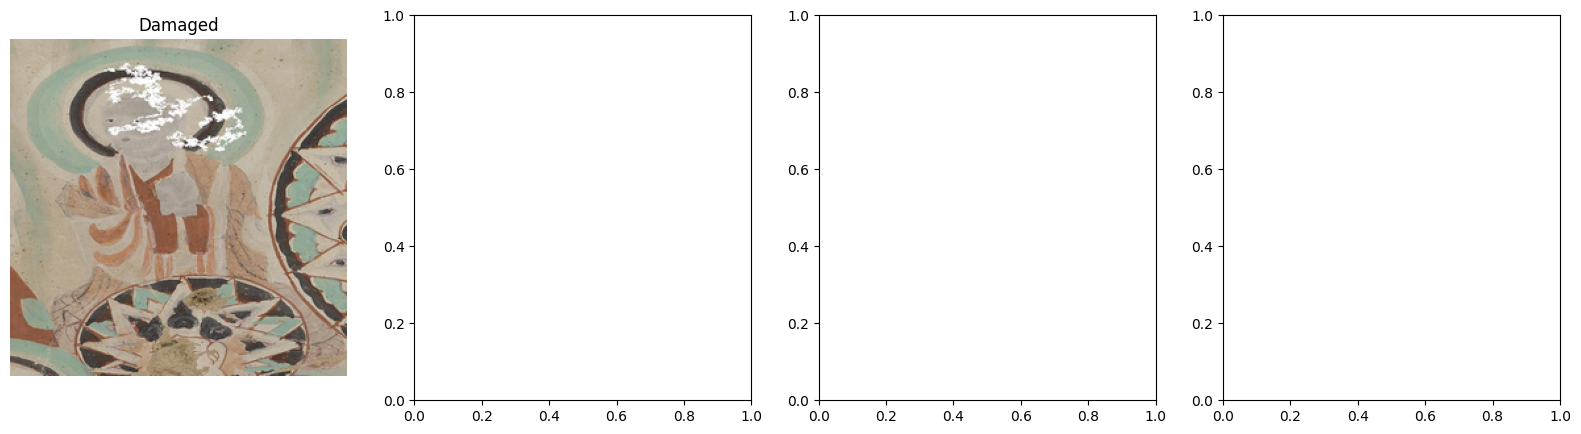

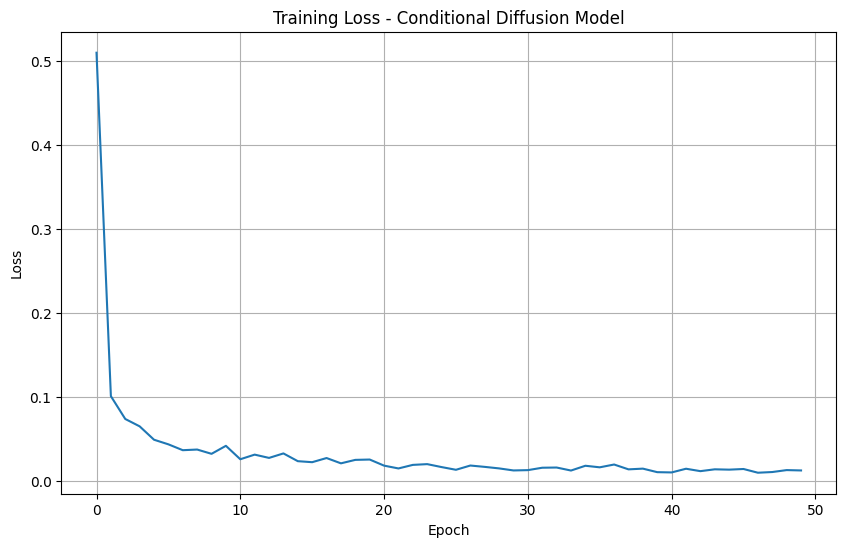


✅ Training completed! Final loss: 0.0124

🎨 Testing final restoration...
Starting image restoration...
🔍 Debug sampling:
  Input damaged range: [-0.976, 1.000]
  Input mask range: [0.000, 1.000]
  Initial noise range: [-4.756, 4.559]
Sampling with 20 steps...


Generating restoration:  25%|██▌       | 5/20 [00:00<00:00, 48.10it/s]

  First predicted noise range: [-4.899, 4.573]
  First predicted noise std: 1.007
  After first denoising step: [-4.703, 4.477]


Generating restoration: 100%|██████████| 20/20 [00:00<00:00, 51.35it/s]


  Final sample range: [-2.962, 2.966]
✅ Restoration completed successfully!

🔍 CRITICAL DEBUG:
🔍 Debug sampling:
  Input damaged range: [-0.976, 1.000]
  Input mask range: [0.000, 1.000]
  Initial noise range: [-4.474, 4.469]
Sampling with 20 steps...


Generating restoration:  30%|███       | 6/20 [00:00<00:00, 57.39it/s]

  First predicted noise range: [-4.478, 4.427]
  First predicted noise std: 1.007
  After first denoising step: [-4.500, 4.377]


Generating restoration: 100%|██████████| 20/20 [00:00<00:00, 54.64it/s]


  Final sample range: [-2.963, 2.959]
Raw output tensor stats:
  Shape: torch.Size([1, 3, 256, 256])
  Range: [-2.963, 2.959]
  Mean: -0.003
  Std: 0.951
After +1/2: [-0.982, 1.980]
After clamp: [0.000, 1.000]
Sample pixel values: tensor([0.6517, 0.4939, 0.9502], device='cuda:0')
✅ PIL conversion successful
Numpy shape: (3, 256, 256)
Numpy dtype: float32
Sample numpy values: [0.6517282  0.49390996 0.9501991 ]


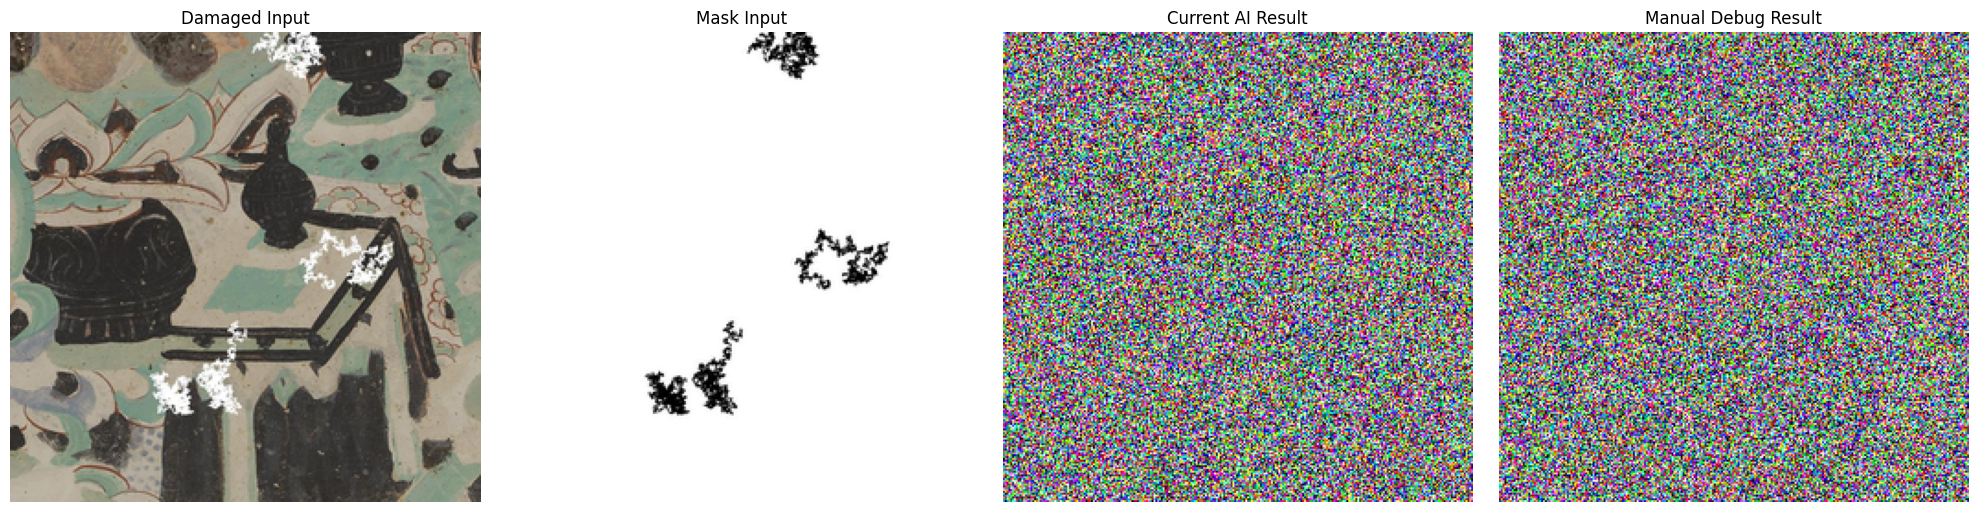

🔍 Comparing restoration methods...
  Testing FIXED AI restoration...
Starting image restoration...
🔍 Debug sampling:
  Input damaged range: [-0.976, 1.000]
  Input mask range: [0.000, 1.000]
  Initial noise range: [-4.748, 4.301]
Sampling with 20 steps...


Generating restoration:  30%|███       | 6/20 [00:00<00:00, 57.68it/s]

  First predicted noise range: [-4.693, 4.229]
  First predicted noise std: 1.007
  After first denoising step: [-4.706, 4.408]


Generating restoration: 100%|██████████| 20/20 [00:00<00:00, 54.44it/s]


  Final sample range: [-2.963, 2.959]
✅ Restoration completed successfully!
  ✅ Fixed AI restoration completed
  Testing CONSERVATIVE AI restoration...
  ❌ Conservative AI restoration failed: 'ConditionalMuralDiffusion' object has no attribute 'restore_image_conservative'


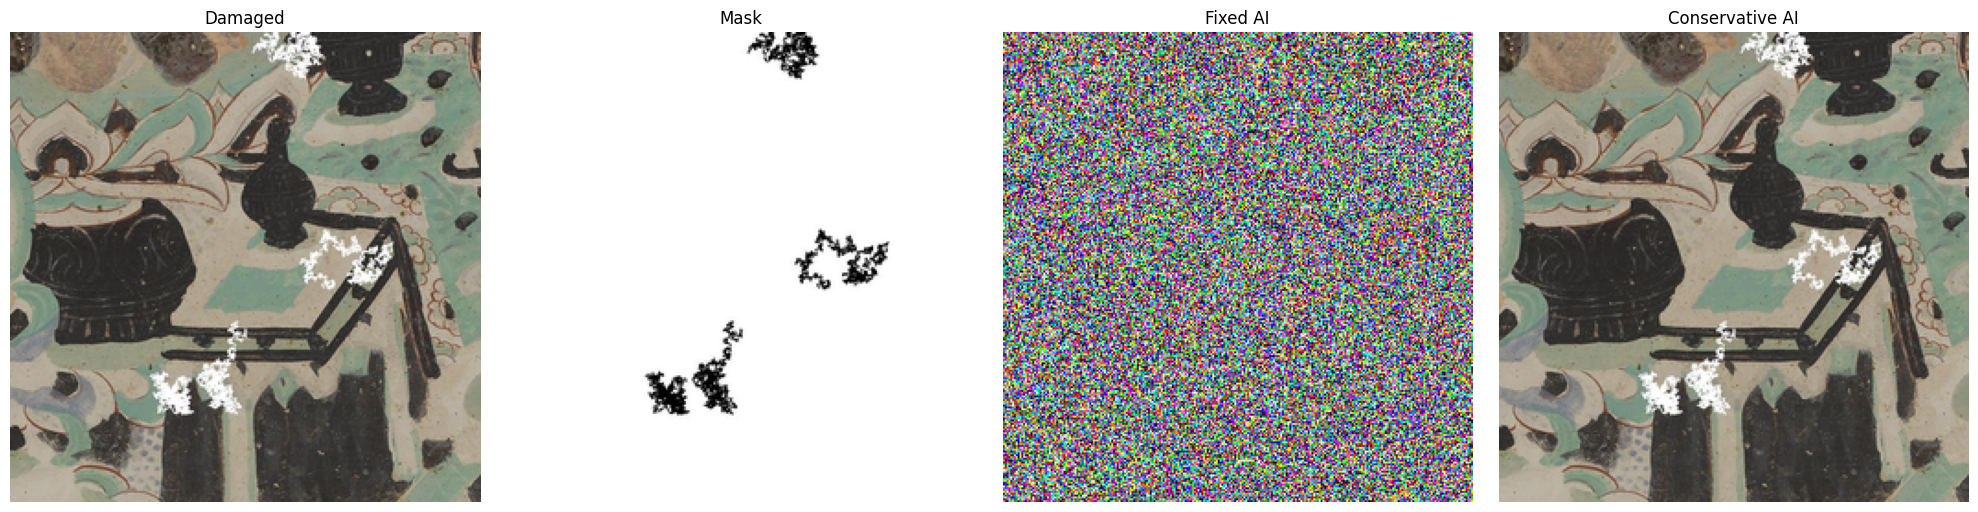

✅ Comparison plot saved successfully!

🎉 SETUP COMPLETE!
Available functions:
1. model.restore_image(image, mask) - Restore single image
2. batch_restore_images(model, damaged_dir, mask_dir, output_dir) - Batch process
3. interactive_restore(image_path, mask_path) - Interactive restoration
4. compare_restoration_methods(image, mask, model) - Compare methods

📊 Model Performance:
   Parameters: 42,872,451
   Training epochs: 50
   Dataset size: 500

💾 Files saved in 'results/' and 'checkpoints/' directories

✅ Everything setup successfully!
You can now restore your 4th century Chinese murals! 🏛️


In [86]:
def quick_restore_example():
    """Example of restoration with ground truth"""
    print("Restoration Example:")
    print("# Load your images")
    print("damaged = Image.open('path/to/damaged.jpg')")
    print("mask = Image.open('path/to/mask.png')")
    print("ground_truth = Image.open('path/to/ground_truth.jpg')")
    print("")
    print("# AI restoration (after training)")
    print("ai_result = model.restore_image(damaged, mask)")
    print("")
    print("# Compare with ground truth")
    print("# ai_result vs ground_truth")
    print("")
    print("# Batch process entire directory")
    print("batch_restore_images(model, 'damaged_dir', 'mask_dir', 'output_dir')")

def training_tips():
    """Training tips and best practices"""
    print("\n🎯 Training Tips:")
    print("1. Start with 10 epochs to see if everything works")
    print("2. Use 50+ epochs for good quality")
    print("3. Monitor the loss - it should decrease steadily")
    print("4. Check sample outputs every 10 epochs")
    print("5. If loss plateaus, try reducing learning rate")
    print("6. More training data = better results")
    print("7. Consistent image sizes work best")

if __name__ == "__main__":
    print("🎨 COMPLETE MURAL RESTORATION SYSTEM")
    print("="*50)

    # Display quick example
    quick_restore_example()
    training_tips()

    print("\n🚀 Starting main program...")
    result = main()

    if result:
        model, train_loader, interactive_restore = result
        print("\n✅ Everything setup successfully!")
        print("You can now restore your 4th century Chinese murals! 🏛️")
    else:
        print("\n❌ Setup failed. Please check the error messages above.")
